In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [3]:
import alpine

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/kv30/KV/ALL_INR_PROJECTS/ALPINE_LIBRARY/alpine/alpine/trainers/base.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import torch
import numpy as np
import skimage.data, skimage.io


from matplotlib import pyplot as plt
from functools import partial
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics import MetricTracker

In [5]:
import alpine

In [6]:
from alpine.models import Siren
from alpine.models.utils import get_coords_nd, get_coords_spatial
from alpine.vis import pca

In [7]:
epochs = 2000
H, W = 256, 256

In [8]:
siren_model = Siren(in_features=2, out_features=3, hidden_features=256, hidden_layers=5, outermost_linear=True).cuda()
print(siren_model)
siren_model.compile()
# siren_model.compile(scheduler=partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda=lambda x:  0.1**min(x/1000,1)))

Siren(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (model): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Sine()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Sine()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Sine()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Sine()
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [9]:
coords = get_coords_spatial(256, 256).cuda()[None,...]
print(coords.shape)

torch.Size([1, 256, 256, 2])


/home/kv30/anaconda3/envs/alpine_env/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
output = siren_model(coords)
print(output['output'].shape)

torch.Size([1, 256, 256, 3])


In [11]:
import skimage.transform

gt_img = skimage.transform.resize(skimage.data.astronaut(), (256,256))
gt = torch.from_numpy(gt_img).float().cuda()[None,...]



In [12]:
print(siren_model)

Siren(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (model): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Sine()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Sine()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Sine()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Sine()
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [13]:
print(epochs, coords.shape)

2000 torch.Size([1, 256, 256, 2])


In [14]:
outputs = siren_model.fit_signal(input=coords, signal=gt, n_iters=epochs, enable_tqdm=True, return_features=True, 
                                    metric_trackers = {'psnr': MetricTracker(PeakSignalNoiseRatio().to('cuda')), 
                                                       'ssim' : MetricTracker(alpine.metrics.SSIM(signal_shape=(H,W)).to('cuda'))
                                                       }, 
                                    track_loss_history=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

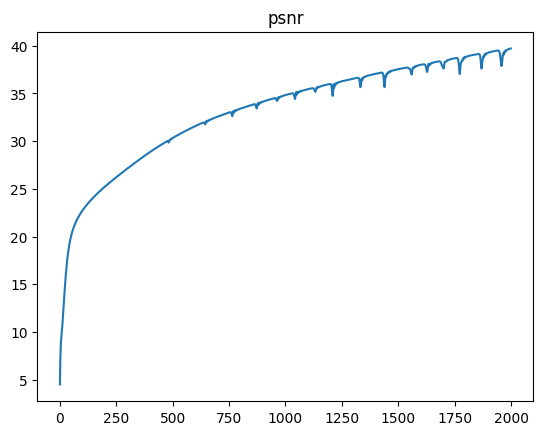

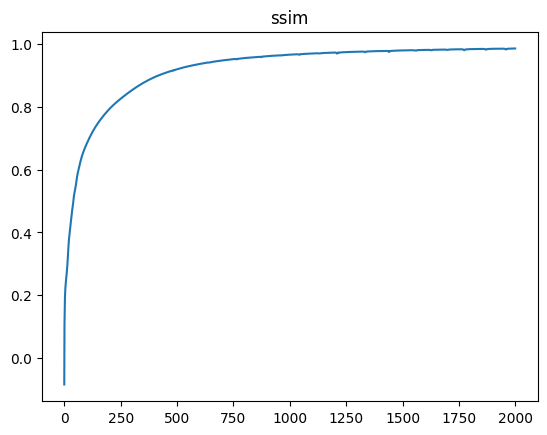

In [15]:
output = outputs['output']
all_metrics = outputs['metrics']
for m, mv in all_metrics.items():
    plt.figure()
    plt.plot(mv.numpy())
    plt.title(m)
    plt.show()

### Visualizing INR output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027883086..1.0379691].


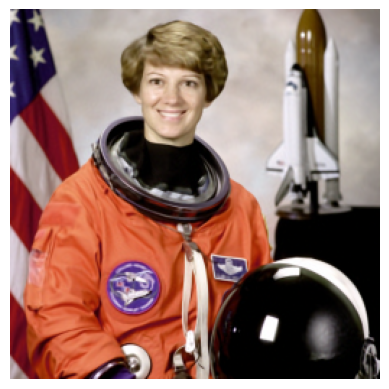

In [16]:
# output = siren_model.render(coords)['output']
plt.figure()
plt.imshow(output.cpu().detach().numpy().reshape(256,256,3))
plt.axis('off')
plt.show()

### Visualizing PCA features of learned INR features

In [17]:
print(outputs.keys())
features = torch.stack(outputs['features'],dim=0).squeeze()
print(features.shape)

dict_keys(['output', 'features', 'loss', 'loss_history', 'metrics', 'metric_trackers'])
torch.Size([4, 256, 256, 256])


In [18]:
feats = pca.compute_pca_features(features[None,...], num_components=5, signal_shape=(256,256))
print(feats.shape)

torch.Size([4, 256, 256, 5])


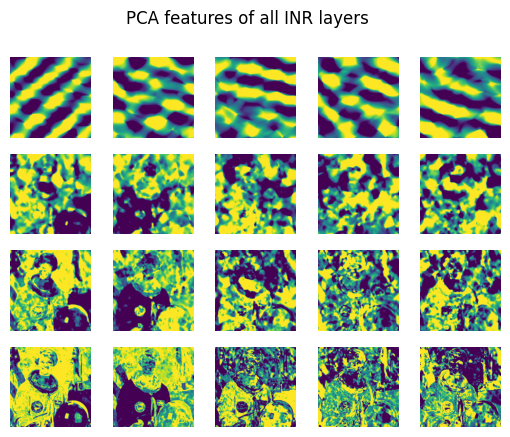

In [19]:
fig, ax = plt.subplots(feats.shape[0], feats.shape[-1])
for i in range(feats.shape[0]):
    for j in range(feats.shape[-1]):
        ax[i,j].imshow(feats[i,...,j].cpu().detach().numpy())
        ax[i,j].axis('off')

plt.suptitle("PCA features of all INR layers")
plt.show()

### Visualizing deep network geometry using Local Complexity by Humayun et.al

In [20]:
from alpine.vis import partitions

In [21]:
NUM_SAMPLED_POINTS = 1024

In [22]:
input_space_subdivision = partitions.get_partitions_from_inr(
    x_bounds=[-1, 1],
    y_bounds=[-1, 1],
    model = siren_model,
    signal_dims = (256, 256),
    sampled_points = NUM_SAMPLED_POINTS,
    sampled_points_batch_sizes= 256,
)

torch.Size([1048576, 4, 2])
LC elapsed time:8.98528
torch.Size([1024, 1024, 5])


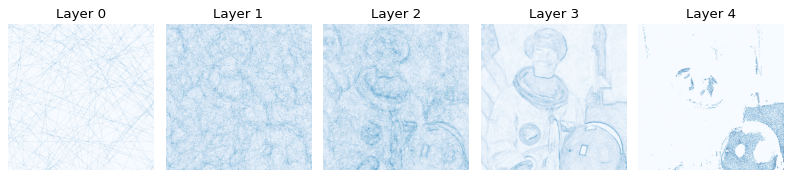

In [23]:
partitions.show_partitions(input_space_subdivision.detach().cpu().numpy(), normalize_each=True, dpi=80)

## Clustering

In [24]:
from alpine.vis import clustering

In [25]:
kk = clustering.KMeans(n_clusters=5)
clusters = kk.fit_predict(features[-1].detach().cpu().numpy().reshape(H*W, -1), new_shape=(H,W))

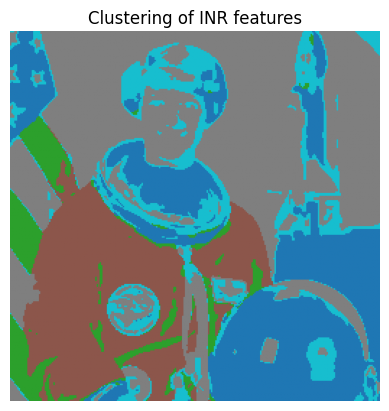

In [26]:
plt.figure()
plt.imshow(clusters, cmap='tab10')
plt.axis('off')
plt.title("Clustering of INR features")
plt.show()
